<a href="https://colab.research.google.com/github/Xboster-eliel/funciones_utiles/blob/main/Convertir_imagen_a_fondo_blanco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from PIL import Image

with Image.open("Foto.jpeg") as img:
    img.save('foto.jpg')

### FONDO BLANCO

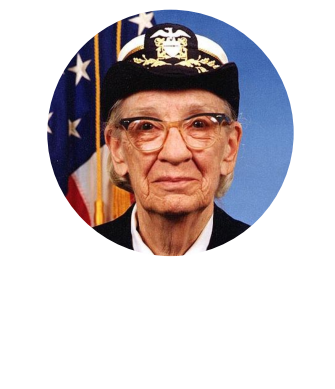

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.cbook as cbook
import matplotlib.patches as patches

with cbook.get_sample_data('grace_hopper.jpg') as image_file:
    image = plt.imread(image_file)

fig, ax = plt.subplots()
im = ax.imshow(image)
patch = patches.Circle((260, 200), radius=200, transform=ax.transData)
im.set_clip_path(patch)

ax.axis('off')
plt.show()

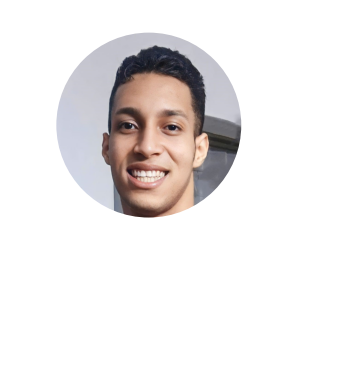

In [ ]:
import matplotlib.pyplot as plt

import matplotlib.cbook as cbook
import matplotlib.patches as patches

with cbook.get_sample_data('/content/drive/MyDrive/Foto.jpg') as image_file:
    image = plt.imread(image_file)

fig, ax = plt.subplots()
im = ax.imshow(image)
patch = patches.Circle((600, 500), radius=400, transform=ax.transData)
im.set_clip_path(patch)

ax.axis('off')
plt.show()

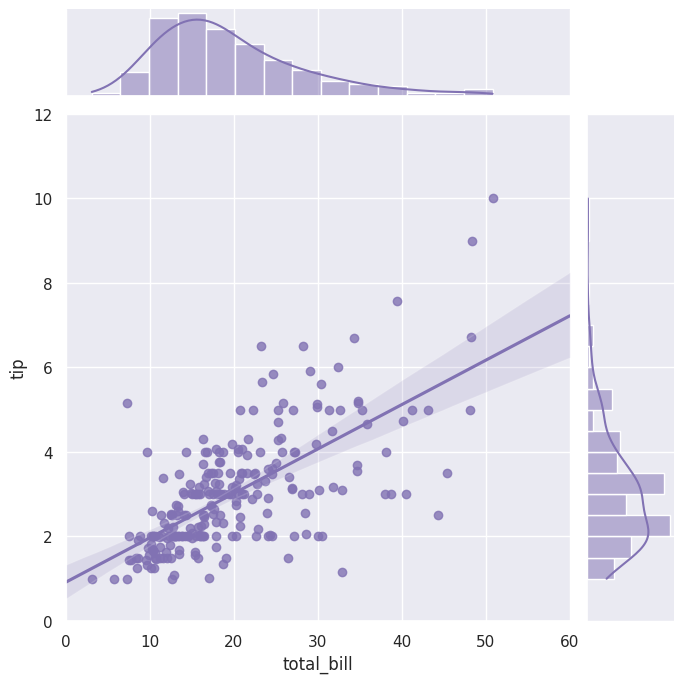

In [ ]:
import seaborn as sns
sns.set_theme(style="darkgrid")

tips = sns.load_dataset("tips")
g = sns.jointplot(x="total_bill", y="tip", data=tips,
                  kind="reg", truncate=False,
                  xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)

# ejemplo plot

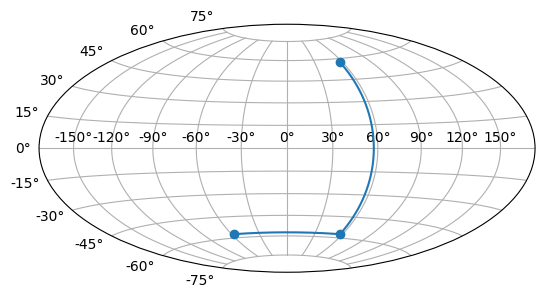

In [ ]:
import numpy as np

import matplotlib
from matplotlib.axes import Axes
import matplotlib.axis as maxis
from matplotlib.patches import Circle
from matplotlib.path import Path
from matplotlib.projections import register_projection
import matplotlib.spines as mspines
from matplotlib.ticker import FixedLocator, Formatter, NullLocator
from matplotlib.transforms import Affine2D, BboxTransformTo, Transform

rcParams = matplotlib.rcParams

# This example projection class is rather long, but it is designed to
# illustrate many features, not all of which will be used every time.
# It is also common to factor out a lot of these methods into common
# code used by a number of projections with similar characteristics
# (see geo.py).


class GeoAxes(Axes):
    """
    An abstract base class for geographic projections
    """
    class ThetaFormatter(Formatter):
        """
        Used to format the theta tick labels.  Converts the native
        unit of radians into degrees and adds a degree symbol.
        """
        def __init__(self, round_to=1.0):
            self._round_to = round_to

        def __call__(self, x, pos=None):
            degrees = round(np.rad2deg(x) / self._round_to) * self._round_to
            return f"{degrees:0.0f}\N{DEGREE SIGN}"

    RESOLUTION = 75

    def _init_axis(self):
        self.xaxis = maxis.XAxis(self)
        self.yaxis = maxis.YAxis(self)
        # Do not register xaxis or yaxis with spines -- as done in
        # Axes._init_axis() -- until GeoAxes.xaxis.clear() works.
        # self.spines['geo'].register_axis(self.yaxis)

    def clear(self):
        # docstring inherited
        super().clear()

        self.set_longitude_grid(30)
        self.set_latitude_grid(15)
        self.set_longitude_grid_ends(75)
        self.xaxis.set_minor_locator(NullLocator())
        self.yaxis.set_minor_locator(NullLocator())
        self.xaxis.set_ticks_position('none')
        self.yaxis.set_ticks_position('none')
        self.yaxis.set_tick_params(label1On=True)
        # Why do we need to turn on yaxis tick labels, but
        # xaxis tick labels are already on?

        self.grid(rcParams['axes.grid'])

        Axes.set_xlim(self, -np.pi, np.pi)
        Axes.set_ylim(self, -np.pi / 2.0, np.pi / 2.0)

    def _set_lim_and_transforms(self):
        # A (possibly non-linear) projection on the (already scaled) data

        # There are three important coordinate spaces going on here:
        #
        # 1. Data space: The space of the data itself
        #
        # 2. Axes space: The unit rectangle (0, 0) to (1, 1)
        #    covering the entire plot area.
        #
        # 3. Display space: The coordinates of the resulting image,
        #    often in pixels or dpi/inch.

        # This function makes heavy use of the Transform classes in
        # ``lib/matplotlib/transforms.py.`` For more information, see
        # the inline documentation there.

        # The goal of the first two transformations is to get from the
        # data space (in this case longitude and latitude) to axes
        # space.  It is separated into a non-affine and affine part so
        # that the non-affine part does not have to be recomputed when
        # a simple affine change to the figure has been made (such as
        # resizing the window or changing the dpi).

        # 1) The core transformation from data space into
        # rectilinear space defined in the HammerTransform class.
        self.transProjection = self._get_core_transform(self.RESOLUTION)

        # 2) The above has an output range that is not in the unit
        # rectangle, so scale and translate it so it fits correctly
        # within the axes.  The peculiar calculations of xscale and
        # yscale are specific to an Aitoff-Hammer projection, so don't
        # worry about them too much.
        self.transAffine = self._get_affine_transform()

        # 3) This is the transformation from axes space to display
        # space.
        self.transAxes = BboxTransformTo(self.bbox)

        # Now put these 3 transforms together -- from data all the way
        # to display coordinates.  Using the '+' operator, these
        # transforms will be applied "in order".  The transforms are
        # automatically simplified, if possible, by the underlying
        # transformation framework.
        self.transData = \
            self.transProjection + \
            self.transAffine + \
            self.transAxes

        # The main data transformation is set up.  Now deal with
        # gridlines and tick labels.

        # Longitude gridlines and ticklabels.  The input to these
        # transforms are in display space in x and axes space in y.
        # Therefore, the input values will be in range (-xmin, 0),
        # (xmax, 1).  The goal of these transforms is to go from that
        # space to display space.  The tick labels will be offset 4
        # pixels from the equator.
        self._xaxis_pretransform = \
            Affine2D() \
            .scale(1.0, self._longitude_cap * 2.0) \
            .translate(0.0, -self._longitude_cap)
        self._xaxis_transform = \
            self._xaxis_pretransform + \
            self.transData
        self._xaxis_text1_transform = \
            Affine2D().scale(1.0, 0.0) + \
            self.transData + \
            Affine2D().translate(0.0, 4.0)
        self._xaxis_text2_transform = \
            Affine2D().scale(1.0, 0.0) + \
            self.transData + \
            Affine2D().translate(0.0, -4.0)

        # Now set up the transforms for the latitude ticks.  The input to
        # these transforms are in axes space in x and display space in
        # y.  Therefore, the input values will be in range (0, -ymin),
        # (1, ymax).  The goal of these transforms is to go from that
        # space to display space.  The tick labels will be offset 4
        # pixels from the edge of the axes ellipse.
        yaxis_stretch = Affine2D().scale(np.pi*2, 1).translate(-np.pi, 0)
        yaxis_space = Affine2D().scale(1.0, 1.1)
        self._yaxis_transform = \
            yaxis_stretch + \
            self.transData
        yaxis_text_base = \
            yaxis_stretch + \
            self.transProjection + \
            (yaxis_space +
             self.transAffine +
             self.transAxes)
        self._yaxis_text1_transform = \
            yaxis_text_base + \
            Affine2D().translate(-8.0, 0.0)
        self._yaxis_text2_transform = \
            yaxis_text_base + \
            Affine2D().translate(8.0, 0.0)

    def _get_affine_transform(self):
        transform = self._get_core_transform(1)
        xscale, _ = transform.transform((np.pi, 0))
        _, yscale = transform.transform((0, np.pi/2))
        return Affine2D() \
            .scale(0.5 / xscale, 0.5 / yscale) \
            .translate(0.5, 0.5)

    def get_xaxis_transform(self, which='grid'):
        """
        Override this method to provide a transformation for the
        x-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        if which not in ['tick1', 'tick2', 'grid']:
            raise ValueError(
                "'which' must be one of 'tick1', 'tick2', or 'grid'")
        return self._xaxis_transform

    def get_xaxis_text1_transform(self, pad):
        return self._xaxis_text1_transform, 'bottom', 'center'

    def get_xaxis_text2_transform(self, pad):
        """
        Override this method to provide a transformation for the
        secondary x-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._xaxis_text2_transform, 'top', 'center'

    def get_yaxis_transform(self, which='grid'):
        """
        Override this method to provide a transformation for the
        y-axis grid and ticks.
        """
        if which not in ['tick1', 'tick2', 'grid']:
            raise ValueError(
                "'which' must be one of 'tick1', 'tick2', or 'grid'")
        return self._yaxis_transform

    def get_yaxis_text1_transform(self, pad):
        """
        Override this method to provide a transformation for the
        y-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._yaxis_text1_transform, 'center', 'right'

    def get_yaxis_text2_transform(self, pad):
        """
        Override this method to provide a transformation for the
        secondary y-axis tick labels.

        Returns a tuple of the form (transform, valign, halign)
        """
        return self._yaxis_text2_transform, 'center', 'left'

    def _gen_axes_patch(self):
        """
        Override this method to define the shape that is used for the
        background of the plot.  It should be a subclass of Patch.

        In this case, it is a Circle (that may be warped by the axes
        transform into an ellipse).  Any data and gridlines will be
        clipped to this shape.
        """
        return Circle((0.5, 0.5), 0.5)

    def _gen_axes_spines(self):
        return {'geo': mspines.Spine.circular_spine(self, (0.5, 0.5), 0.5)}

    def set_yscale(self, *args, **kwargs):
        if args[0] != 'linear':
            raise NotImplementedError

    # Prevent the user from applying scales to one or both of the
    # axes.  In this particular case, scaling the axes wouldn't make
    # sense, so we don't allow it.
    set_xscale = set_yscale

    # Prevent the user from changing the axes limits.  In our case, we
    # want to display the whole sphere all the time, so we override
    # set_xlim and set_ylim to ignore any input.  This also applies to
    # interactive panning and zooming in the GUI interfaces.
    def set_xlim(self, *args, **kwargs):
        raise TypeError("Changing axes limits of a geographic projection is "
                        "not supported.  Please consider using Cartopy.")

    set_ylim = set_xlim

    def format_coord(self, lon, lat):
        """
        Override this method to change how the values are displayed in
        the status bar.

        In this case, we want them to be displayed in degrees N/S/E/W.
        """
        lon, lat = np.rad2deg([lon, lat])
        ns = 'N' if lat >= 0.0 else 'S'
        ew = 'E' if lon >= 0.0 else 'W'
        return ('%f\N{DEGREE SIGN}%s, %f\N{DEGREE SIGN}%s'
                % (abs(lat), ns, abs(lon), ew))

    def set_longitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.

        This is an example method that is specific to this projection
        class -- it provides a more convenient interface to set the
        ticking than set_xticks would.
        """
        # Skip -180 and 180, which are the fixed limits.
        grid = np.arange(-180 + degrees, 180, degrees)
        self.xaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.xaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def set_latitude_grid(self, degrees):
        """
        Set the number of degrees between each longitude grid.

        This is an example method that is specific to this projection
        class -- it provides a more convenient interface than
        set_yticks would.
        """
        # Skip -90 and 90, which are the fixed limits.
        grid = np.arange(-90 + degrees, 90, degrees)
        self.yaxis.set_major_locator(FixedLocator(np.deg2rad(grid)))
        self.yaxis.set_major_formatter(self.ThetaFormatter(degrees))

    def set_longitude_grid_ends(self, degrees):
        """
        Set the latitude(s) at which to stop drawing the longitude grids.

        Often, in geographic projections, you wouldn't want to draw
        longitude gridlines near the poles.  This allows the user to
        specify the degree at which to stop drawing longitude grids.

        This is an example method that is specific to this projection
        class -- it provides an interface to something that has no
        analogy in the base Axes class.
        """
        self._longitude_cap = np.deg2rad(degrees)
        self._xaxis_pretransform \
            .clear() \
            .scale(1.0, self._longitude_cap * 2.0) \
            .translate(0.0, -self._longitude_cap)

    def get_data_ratio(self):
        """
        Return the aspect ratio of the data itself.

        This method should be overridden by any Axes that have a
        fixed data ratio.
        """
        return 1.0

    # Interactive panning and zooming is not supported with this projection,
    # so we override all of the following methods to disable it.
    def can_zoom(self):
        """
        Return whether this Axes supports the zoom box button functionality.

        This Axes object does not support interactive zoom box.
        """
        return False

    def can_pan(self):
        """
        Return whether this Axes supports the pan/zoom button functionality.

        This Axes object does not support interactive pan/zoom.
        """
        return False

    def start_pan(self, x, y, button):
        pass

    def end_pan(self):
        pass

    def drag_pan(self, button, key, x, y):
        pass


class HammerAxes(GeoAxes):
    """
    A custom class for the Aitoff-Hammer projection, an equal-area map
    projection.

    https://en.wikipedia.org/wiki/Hammer_projection
    """

    # The projection must specify a name. This will be used by the
    # user to select the projection,
    # i.e. ``subplot(projection='custom_hammer')``.
    name = 'custom_hammer'

    class HammerTransform(Transform):
        """The base Hammer transform."""
        input_dims = output_dims = 2

        def __init__(self, resolution):
            """
            Create a new Hammer transform.  Resolution is the number of steps
            to interpolate between each input line segment to approximate its
            path in curved Hammer space.
            """
            Transform.__init__(self)
            self._resolution = resolution

        def transform_non_affine(self, ll):
            longitude, latitude = ll.T

            # Pre-compute some values
            half_long = longitude / 2
            cos_latitude = np.cos(latitude)
            sqrt2 = np.sqrt(2)

            alpha = np.sqrt(1 + cos_latitude * np.cos(half_long))
            x = (2 * sqrt2) * (cos_latitude * np.sin(half_long)) / alpha
            y = (sqrt2 * np.sin(latitude)) / alpha
            return np.column_stack([x, y])

        def transform_path_non_affine(self, path):
            # vertices = path.vertices
            ipath = path.interpolated(self._resolution)
            return Path(self.transform(ipath.vertices), ipath.codes)

        def inverted(self):
            return HammerAxes.InvertedHammerTransform(self._resolution)

    class InvertedHammerTransform(Transform):
        input_dims = output_dims = 2

        def __init__(self, resolution):
            Transform.__init__(self)
            self._resolution = resolution

        def transform_non_affine(self, xy):
            x, y = xy.T
            z = np.sqrt(1 - (x / 4) ** 2 - (y / 2) ** 2)
            longitude = 2 * np.arctan((z * x) / (2 * (2 * z ** 2 - 1)))
            latitude = np.arcsin(y*z)
            return np.column_stack([longitude, latitude])

        def inverted(self):
            return HammerAxes.HammerTransform(self._resolution)

    def __init__(self, *args, **kwargs):
        self._longitude_cap = np.pi / 2.0
        super().__init__(*args, **kwargs)
        self.set_aspect(0.5, adjustable='box', anchor='C')
        self.clear()

    def _get_core_transform(self, resolution):
        return self.HammerTransform(resolution)


# Now register the projection with Matplotlib so the user can select it.
register_projection(HammerAxes)


if __name__ == '__main__':
    import matplotlib.pyplot as plt

    # Now make a simple example using the custom projection.
    fig, ax = plt.subplots(subplot_kw={'projection': 'custom_hammer'})
    ax.plot([-1, 1, 1], [-1, -1, 1], "o-")
    ax.grid()

    plt.show()

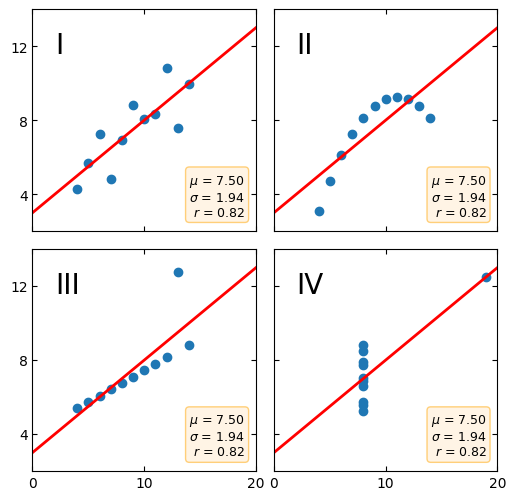

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x = [10, 8, 13, 9, 11, 14, 6, 4, 12, 7, 5]
y1 = [8.04, 6.95, 7.58, 8.81, 8.33, 9.96, 7.24, 4.26, 10.84, 4.82, 5.68]
y2 = [9.14, 8.14, 8.74, 8.77, 9.26, 8.10, 6.13, 3.10, 9.13, 7.26, 4.74]
y3 = [7.46, 6.77, 12.74, 7.11, 7.81, 8.84, 6.08, 5.39, 8.15, 6.42, 5.73]
x4 = [8, 8, 8, 8, 8, 8, 8, 19, 8, 8, 8]
y4 = [6.58, 5.76, 7.71, 8.84, 8.47, 7.04, 5.25, 12.50, 5.56, 7.91, 6.89]

datasets = {
    'I': (x, y1),
    'II': (x, y2),
    'III': (x, y3),
    'IV': (x4, y4)
}

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(6, 6),
                        gridspec_kw={'wspace': 0.08, 'hspace': 0.08})
axs[0, 0].set(xlim=(0, 20), ylim=(2, 14))
axs[0, 0].set(xticks=(0, 10, 20), yticks=(4, 8, 12))

for ax, (label, (x, y)) in zip(axs.flat, datasets.items()):
    ax.text(0.1, 0.9, label, fontsize=20, transform=ax.transAxes, va='top')
    ax.tick_params(direction='in', top=True, right=True)
    ax.plot(x, y, 'o')

    # linear regression
    p1, p0 = np.polyfit(x, y, deg=1)  # slope, intercept
    ax.axline(xy1=(0, p0), slope=p1, color='r', lw=2)

    # add text box for the statistics
    stats = (f'$\\mu$ = {np.mean(y):.2f}\n'
             f'$\\sigma$ = {np.std(y):.2f}\n'
             f'$r$ = {np.corrcoef(x, y)[0][1]:.2f}')
    bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
    ax.text(0.95, 0.07, stats, fontsize=9, bbox=bbox,
            transform=ax.transAxes, horizontalalignment='right')

plt.show()

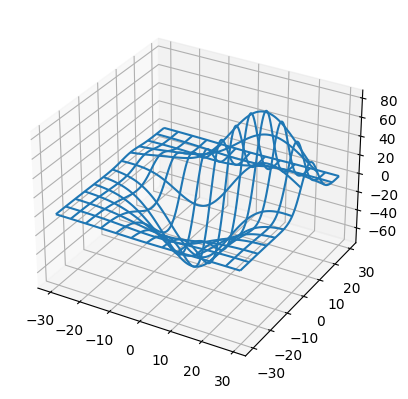

In [ ]:
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Grab some test data.
X, Y, Z = axes3d.get_test_data(0.05)

# Plot a basic wireframe.
ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10)

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.cbook import get_sample_data
from matplotlib.colors import LightSource

dem = get_sample_data('jacksboro_fault_dem.npz')
z = dem['elevation']
# -- Optional dx and dy for accurate vertical exaggeration --------------------
# If you need topographically accurate vertical exaggeration, or you don't want
# to guess at what *vert_exag* should be, you'll need to specify the cellsize
# of the grid (i.e. the *dx* and *dy* parameters).  Otherwise, any *vert_exag*
# value you specify will be relative to the grid spacing of your input data
# (in other words, *dx* and *dy* default to 1.0, and *vert_exag* is calculated
# relative to those parameters).  Similarly, *dx* and *dy* are assumed to be in
# the same units as your input z-values.  Therefore, we'll need to convert the
# given dx and dy from decimal degrees to meters.
dx, dy = dem['dx'], dem['dy']
dy = 111200 * dy
dx = 111200 * dx * np.cos(np.radians(dem['ymin']))
# -----------------------------------------------------------------------------

# Shade from the northwest, with the sun 45 degrees from horizontal
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gist_earth

fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(8, 9))
plt.setp(axs.flat, xticks=[], yticks=[])

# Vary vertical exaggeration and blend mode and plot all combinations
for col, ve in zip(axs.T, [0.1, 1, 10]):
    # Show the hillshade intensity image in the first row
    col[0].imshow(ls.hillshade(z, vert_exag=ve, dx=dx, dy=dy), cmap='gray')

    # Place hillshaded plots with different blend modes in the rest of the rows
    for ax, mode in zip(col[1:], ['hsv', 'overlay', 'soft']):
        rgb = ls.shade(z, cmap=cmap, blend_mode=mode,
                       vert_exag=ve, dx=dx, dy=dy)
        ax.imshow(rgb)

# Label rows and columns
for ax, ve in zip(axs[0], [0.1, 1, 10]):
    ax.set_title(f'{ve}', size=18)
for ax, mode in zip(axs[:, 0], ['Hillshade', 'hsv', 'overlay', 'soft']):
    ax.set_ylabel(mode, size=18)

# Group labels...
axs[0, 1].annotate('Vertical Exaggeration', (0.5, 1), xytext=(0, 30),
                   textcoords='offset points', xycoords='axes fraction',
                   ha='center', va='bottom', size=20)
axs[2, 0].annotate('Blend Mode', (0, 0.5), xytext=(-30, 0),
                   textcoords='offset points', xycoords='axes fraction',
                   ha='right', va='center', size=20, rotation=90)
fig.subplots_adjust(bottom=0.05, right=0.95)

plt.show()

<ipython-input-5-f729e5a7e80c>:7: MatplotlibDeprecationWarning: In a future release, get_sample_data will automatically load numpy arrays.  Set np_load to True to get the array and suppress this warning.  Set asfileobj to False to get the path to the data file and suppress this warning.
  dem = get_sample_data('jacksboro_fault_dem.npz')


TypeError: ignored